*Note: Training logs one step per train batch and one step per val batch, so step curves differ in length. Epoch curves aggregate them for aligned comparison.*


# PIONEER ML Tutorial

Quick walkthrough of the pipeline framework, Lightning utilities, and how to plug in a model. This notebook builds a tiny synthetic dataset, wraps it in a DataModule, trains a model with the Lightning pipeline stage, and inspects results.

## 1) Imports

In [1]:
import sys, pathlib

def _find_repo_root(start: pathlib.Path) -> pathlib.Path:
    for path in [start, *start.parents]:
        if (path / 'pyproject.toml').exists():
            return path
    return start

repo_root = _find_repo_root(pathlib.Path.cwd())
src_dir = repo_root / 'src'
for candidate in (repo_root, src_dir):
    if str(candidate) not in sys.path:
        sys.path.insert(0, str(candidate))

print('Added to sys.path:', repo_root)
print('Added to sys.path:', src_dir)


Added to sys.path: /home/jack/python_projects/pioneerML
Added to sys.path: /home/jack/python_projects/pioneerML/src


In [2]:
# Loss curves (steps)
plot_loss_curves(
    train_losses=lightning_module.train_loss_history,
    val_losses=lightning_module.val_loss_history,
    title='Loss per step',
    xlabel='Step',
    show=True,
)

# Loss curves (epochs) for aligned lengths
if lightning_module.train_epoch_loss_history:
    plot_loss_curves(
        train_losses=lightning_module.train_epoch_loss_history,
        val_losses=lightning_module.val_epoch_loss_history,
        title='Loss per epoch',
        xlabel='Epoch',
        show=True,
    )


## 2) Create a synthetic dataset
We generate a few fake time-group records with the standardized per-hit fields expected by `GraphGroupDataset`.

In [3]:
def make_record(num_hits: int, event_id: int) -> dict:
    coord = np.random.randn(num_hits).astype(np.float32)
    z = np.random.randn(num_hits).astype(np.float32)
    energy = np.abs(np.random.randn(num_hits)).astype(np.float32)
    view = np.random.randint(0, 2, num_hits).astype(np.float32)

    # Multi-label targets: [pion, muon, mip]
    labels = [int(energy.mean() > 0.5), int(num_hits % 2 == 0)]
    if len(labels) < 3:
        labels.append(0)

    return {
        "coord": coord,
        "z": z,
        "energy": energy,
        "view": view,
        "labels": labels,
        "event_id": event_id,
        "group_id": event_id,
    }

records = [make_record(num_hits=8 + i, event_id=i) for i in range(20)]
dataset = GraphGroupDataset(records, num_classes=3)
dataset[0]  # trigger a build and inspect

Data(x=[8, 5], edge_index=[2, 56], edge_attr=[56, 4], y=[3], event_id=0, group_id=0)

## 3) Wrap data with a Lightning DataModule
Splits the dataset and prepares PyG loaders.

In [4]:
datamodule = GraphDataModule(dataset=dataset, batch_size=4, val_split=0.2, test_split=0.0, num_workers=2)
datamodule.setup()
datamodule.train_dataloader(), datamodule.val_dataloader()


(<torch_geometric.loader.dataloader.DataLoader at 0x7ade6a2fe710>,
 <torch_geometric.loader.dataloader.DataLoader at 0x7ade6a2fe490>)

## 4) Build the model and Lightning module

In [5]:
model = GroupClassifier(num_classes=3, hidden=64, num_blocks=2)
lightning_module = GraphLightningModule(model, task="classification", lr=1e-3)
lightning_module


GraphLightningModule(
  (model): GroupClassifier(
    (input_embed): Linear(in_features=5, out_features=64, bias=True)
    (blocks): ModuleList(
      (0-1): 2 x FullGraphTransformerBlock(
        (ln1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): TransformerConv(64, 16, heads=4)
        (ln2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=256, out_features=64, bias=True)
        )
      )
    )
    (jk): JumpingKnowledge(cat)
    (pool): AttentionalAggregation(gate_nn=Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=1, bias=True)
    ), nn=None)
    (head): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1

## 5) Compose a pipeline with the Lightning training stage
The `LightningTrainStage` fits the module using any provided DataModule and records the trainer + trained module back into the shared `Context`.

In [6]:
train_stage = LightningTrainStage(
    config=StageConfig(
        name="train",
        params={
            "module": lightning_module,
            "datamodule": datamodule,
            "trainer_params": {
                "max_epochs": 3,
                "limit_train_batches": 3,
                "limit_val_batches": 1,
                "logger": False,
                "enable_checkpointing": False,
                "accelerator": "auto",
                "devices": 1,           # pick GPU 0
                "precision": "16-mixed",
                "enable_model_summary": False,
            },
        },
    )
)

pipeline = Pipeline([train_stage], name="tutorial_pipeline")
ctx = pipeline.run(Context())
ctx.summary()
ctx.get("metrics", {})


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


{'val_loss': 0.012993223965168,
 'val_accuracy': 1.0,
 'train_loss': 0.024641990661621094,
 'train_accuracy': 1.0}

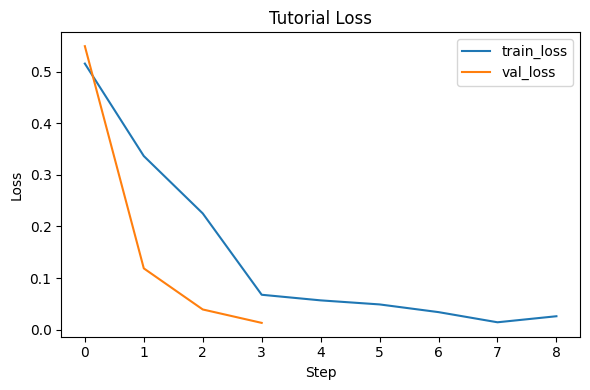

In [7]:
# Plot loss curves
plot_loss_curves(
    train_losses=lightning_module.train_loss_history,
    val_losses=lightning_module.val_loss_history,
    title='Tutorial Loss',
    show=True,
)


## 6) Next steps
- Swap in your own datasets or DataModules.
- Add stages for preprocessing, evaluation, and checkpointing.
- Integrate experiment tracking (e.g., Weights & Biases) by configuring the Lightning Trainer.